In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import json
import csv
import seaborn as sns

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation

In [2]:
os.environ["CUAD_VISIBLE_DEVICES"]='0'
os.environ["CUAD_VISIBLE_DEVICES"]='1'

In [3]:
MMS = MinMaxScaler() # MinMaxScaler
le = LabelEncoder() # LabelEncoder
enc = OneHotEncoder() # OneHotEncoder

# 데이터 호출

In [4]:
axis = pd.read_csv('/home/master/Jibum/Motion_Show/HAR/Final/training_data.csv')

# 독립변수, 종속변수 선언

In [5]:
feature = axis.iloc[:,:-1]
label = axis['activity']

# 라벨인코딩

In [6]:
le.fit(label)
label = le.transform(label)
print(label, type(label), label.shape, le.classes_)

[0 0 0 ... 1 1 1] <class 'numpy.ndarray'> (44946,) ['sit' 'stand' 'walking']


# SMOTE 알고리즘

In [7]:
import imblearn
from collections import Counter
print(imblearn.__version__)

def count_and_plot(label):
    counter = Counter(label)
    
    for i,j in counter.items():
        print("Class = %d, n = %d (%.3f%%)" % (i, j, j/len(label)*100))
    
    plt.bar(counter.keys(), counter.values())
    plt.show()

0.8.1


Class = 0, n = 15328 (34.103%)
Class = 2, n = 12429 (27.653%)
Class = 1, n = 17189 (38.244%)


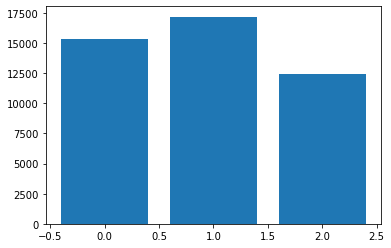

In [8]:
count_and_plot(label)

Class = 0, n = 17189 (33.333%)
Class = 2, n = 17189 (33.333%)
Class = 1, n = 17189 (33.333%)


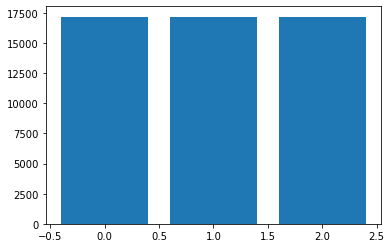

In [9]:
from imblearn.over_sampling import SMOTE
feature_resampled, label_resampled = SMOTE(random_state=0).fit_resample(feature,label)
count_and_plot(label_resampled)

In [10]:
label_resampled = np_utils.to_categorical(label_resampled)

# 스케일링 적용

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

nor = Normalizer() 
rob = RobustScaler() 
sc = StandardScaler() 


# feature_resampled = nor.fit_transform(feature_resampled)
feature_resampled = rob.fit_transform(feature_resampled)
# feature_resampled = sc.fit_transform(feature_resampled)


In [12]:
print("독립변수 : {}".format(feature_resampled.shape))
print("종속변수 : {}".format(label_resampled.shape))

독립변수 : (51567, 27)
종속변수 : (51567, 3)


# 데이터 분리

In [13]:
def split(data,target):
    x_train_all, x_test, y_train_all, y_test = train_test_split(data, target, stratify=target, test_size=0.2, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
    return x_train_all, x_train, x_val, x_test, y_train_all, y_train, y_val, y_test
    

In [14]:
x_train_all, x_train, x_val, x_test, y_train_all, y_train, y_val, y_test = split(feature_resampled,label_resampled)
print(x_train_all.shape)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train_all.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(41253, 27)
(33002, 27)
(8251, 27)
(10314, 27)
(41253, 3)
(33002, 3)
(8251, 3)
(10314, 3)


# 모델 설계

In [15]:
from tensorflow import keras

def create_model():
    model = Sequential([
        keras.layers.Dense(units=100, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=50, activation='relu'),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax') 
    ])
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)


In [16]:
model = create_model()

history = model.fit(x_train,y_train, epochs=100, validation_data = (x_val,y_val), callbacks=[early_stop])

Epoch 1/100
1032/1032 [==============================] - 3s 2ms/step - loss: 0.1208 - accuracy: 0.9610 - val_loss: 0.0769 - val_accuracy: 0.9742
Epoch 2/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0659 - accuracy: 0.9808 - val_loss: 0.0559 - val_accuracy: 0.9832
Epoch 3/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0576 - accuracy: 0.9828 - val_loss: 0.0440 - val_accuracy: 0.9867
Epoch 4/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0428 - accuracy: 0.9861 - val_loss: 0.0389 - val_accuracy: 0.9852
Epoch 5/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0329 - accuracy: 0.9892 - val_loss: 0.0313 - val_accuracy: 0.9885
Epoch 6/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0299 - val_accuracy: 0.9882
Epoch 7/100
1032/1032 [==============================] - 2s 2ms/step - loss: 0.0212 - accuracy: 0.9930 - val_loss: 0.0116 - val_ac

Text(0, 0.5, 'Loss')

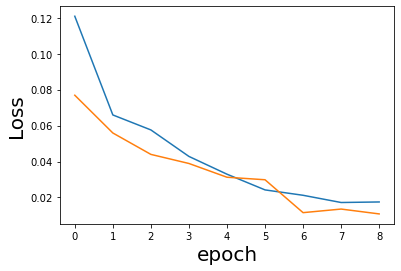

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)
# plt.savefig('loss.png')

Text(0, 0.5, 'Accuracy')

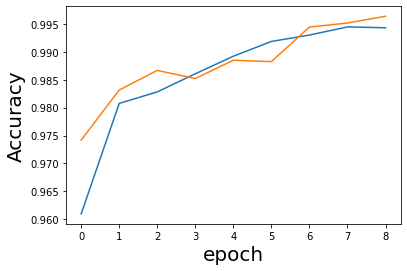

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
# plt.savefig('acc.png')

In [19]:
loss,acc = model.evaluate(x_train,y_train, verbose=2)
print("train_model acc : {}".format(100*acc))
print("train_model loss : {}".format(100*loss))

loss, acc = model.evaluate(x_test,y_test, verbose=2)
print("test_model acc : {}%".format(100*acc))
print("test_model loss : {}".format(100*loss))


1032/1032 - 1s - loss: 0.0099 - accuracy: 0.9970
train_model acc : 99.69698786735535
train_model loss : 0.9866602718830109
323/323 - 0s - loss: 0.0109 - accuracy: 0.9967
test_model acc : 99.67035055160522%
test_model loss : 1.0928941890597343


In [ ]:
def create_model1():
    model1 = Sequential([
        keras.layers.Dense(units=50, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=15, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax') 
    ])
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model1

In [ ]:
model1 = create_model1()

history = model1.fit(x_train,y_train, epochs=100, validation_data = (x_val,y_val), callbacks=[early_stop])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)

# plt.savefig('loss.png')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epoch",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)

# plt.savefig('acc.png')

In [ ]:
loss,acc = model1.evaluate(x_train,y_train, verbose=2)
print("train_model acc : {}".format(100*acc))
print("train_model loss : {}".format(100*loss))

loss, acc = model1.evaluate(x_test,y_test, verbose=2)
print("test_model acc : {}%".format(100*acc))
print("test_model loss : {}".format(100*loss))

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model2(learning_rate):
    model2 = Sequential([
        keras.layers.Dense(units=50, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=15, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])
    model2.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2, epochs=100, verbose=0)
param_grid = {'learning_rate':[0.1,0.01,0.001,0.0001]}
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model2, param_grid = param_grid,cv=3)
grid_result = grid.fit(x_train,y_train)

In [ ]:
print(grid.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model2(nu1,nu2,nu3,learning_rate=0.01):
    model2 = Sequential([
        keras.layers.Dense(nu1, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(nu2, activation='relu'),
        keras.layers.Dense(nu3, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2, epochs=100, verbose=0)
param_grid = {'nu1':[100,50],
              'nu2':[50,25],
              'nu3':[25,15]}
# param_grid = {'learning_rate':[0.1,0.01,0.001,0.0001]}
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model2, param_grid = param_grid,cv=3)
grid_result = grid.fit(x_train,y_train)

In [ ]:
print(grid.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model2(optimizer,learning_rate=0.01):
    model2 = Sequential([
        keras.layers.Dense(units=50, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(units=25, activation='relu'),
        keras.layers.Dense(units=15, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2, epochs=100, verbose=0)
# param_grid = {'learning_rate':[0.1,0.01,0.001,0.0001]}
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model2, param_grid = param_grid,cv=3)
grid_result = grid.fit(x_train,y_train)

In [ ]:
print(grid.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model2(nu3,learning_rate=0.01):
    model2 = Sequential([
        keras.layers.Dense(100, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(nu3, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])
#     opt = keras.optimizers.Adam(learning_rate=0.01)
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2, epochs=100, verbose=0)
# param_grid = {'nu1':[100,50],
#               'nu2':[50,25],
#               'nu3':[25,15],
#               'optimizer':['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

# param_grid = {'learning_rate':[0.1,0.01,0.001,0.0001]}
param_grid = {'nu3':[25,15]}

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model2, param_grid = param_grid,cv=3)
grid_result = grid.fit(x_train,y_train)

In [ ]:
print(grid.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
print(grid_result)

In [20]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model2(nu1,nu2,nu3,optimizer,learning_rate=0.01):
    model2 = Sequential([
        keras.layers.Dense(nu1, activation='sigmoid', input_shape=(27,)),
        keras.layers.Dense(nu2, activation='relu'),
        keras.layers.Dense(nu3, activation='relu'),
        keras.layers.Dense(units=3, activation='softmax')
    ])
#     opt = keras.optimizers.Adam(learning_rate=0.01)
    model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model2

model2 = KerasClassifier(build_fn=create_model2, epochs=100, verbose=0)
param_grid = {'nu1':[100,50],
              'nu2':[50,25],
              'nu3':[25,15],
              'optimizer':['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']}

# param_grid = {'learning_rate':[0.1,0.01,0.001,0.0001]}
# param_grid = {'nu3':[25,15]}

# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model2, param_grid = param_grid,cv=3)
grid_result = grid.fit(x_train,y_train)

In [21]:
print(grid_result)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f6ab0ece310>,
             param_grid={'nu1': [100, 50], 'nu2': [50, 25], 'nu3': [25, 15],
                         'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta',
                                       'Adam', 'Adamax', 'Nadam']})


In [22]:
print(grid.best_params_)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

{'nu1': 100, 'nu2': 50, 'nu3': 15, 'optimizer': 'Nadam'}
Best: 0.998970 using {'nu1': 100, 'nu2': 50, 'nu3': 15, 'optimizer': 'Nadam'}
